# Phase 1, Phase 2 tests

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../experiments/")
import base_vae_hardem

In [3]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_VISIBLE_DEVICES"] = "0"

In [4]:
import jax
import hlax
import tomli
import distrax
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from functools import partial
from itertools import product

In [5]:
%config InlineBackend.figure_format = "retina"

In [6]:
def build_mll_summary(res, procedure):
    df_mll = pd.DataFrame(res["test"]["hist_loss"]).melt(var_name="episode", value_name="mll")
    df_mll["procedure"] = procedure

    df_times = pd.DataFrame.from_dict({"times": res["train"]["times"]}, orient="index").T
    df_mll = pd.merge(df_mll, df_times, left_on="episode", right_index=True)
    return df_mll

## Loss functions

In [7]:
def iwae_bern(key, params, apply_fn, X_batch):
    """
    Importance-weighted marginal log-likelihood for
    a Bernoulli decoder and Gaussian encoder
    """
    batch_size = len(X_batch)

    encode_decode = apply_fn(params, X_batch, key)
    z, (mean_z, logvar_z), logit_mean_x = encode_decode
    _, num_is_samples, dim_latent = z.shape

    std_z = jnp.exp(logvar_z / 2)
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent),
                                                jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    dist_posterior = distrax.Normal(mean_z[None, ...], std_z[None, ...])

    log_prob_z_prior = dist_prior.log_prob(z)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)
    log_prob_z_post = dist_posterior.log_prob(z).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x - log_prob_z_post

    niwmll = jax.nn.logsumexp(log_prob, axis=-1, b=1/num_is_samples).mean()
    return niwmll


def hard_nmll_bern(params, z_batch, X_batch, model):
    """
    Loss function
    -------------

    Negative Marginal log-likelihood for hard EM
    assuming an isotropic Gaussian prior with zero mean
    and a decoder with a diagonal covariance matrix

    Parameters
    ----------
    params: pytree
        Parameters of the decoder model, i.e.,
        model.apply(params, z_batch) = X_batch (approx)
    z_batch: jnp.ndarray
        Batch of latent variables
    X_batch: jnp.ndarray
        Batch of observations
    model: flax.nn.Module
        Decoder model (input z -> output x)
    """
    dim_latent = model.dim_latent

    logit_mean_x = model.apply(params, z_batch)

    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)

    log_prob_z_prior = dist_prior.log_prob(z_batch)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x

    return -log_prob.mean()


def neg_iwmll_bern(key, params_encoder, params_decoder, observation,
              encoder, decoder, num_is_samples=10):
    """
    Importance-weighted marginal log-likelihood for an unamortised, uncoditional
    gaussian encoder.
    """
    latent_samples, (mu_z, std_z) = encoder.apply(
        params_encoder, key, num_samples=num_is_samples
    )

    _, dim_latent = latent_samples.shape
    # log p(x|z)
    logit_mean_x = decoder.apply(params_decoder, latent_samples)
    log_px_cond = distrax.Bernoulli(logits=logit_mean_x).log_prob(observation).sum(axis=-1)

    # log p(z)
    mu_z_init, std_z_init = jnp.zeros(dim_latent), jnp.ones(dim_latent)
    log_pz = distrax.MultivariateNormalDiag(mu_z_init, std_z_init).log_prob(latent_samples)

    # log q(z)
    log_qz = distrax.MultivariateNormalDiag(mu_z, std_z).log_prob(latent_samples)

    # Importance-weighted marginal log-likelihood
    log_prob = log_pz + log_px_cond - log_qz
    niwmll = -jax.nn.logsumexp(log_prob, axis=-1, b=1/num_is_samples)
    return niwmll



def neg_iwmll_bern_delta(key, params_encoder, params_decoder, observation,
              encoder, decoder, num_is_samples=10):
    """
    Importance-weighted marginal log-likelihood for an unamortised, uncoditional
    gaussian encoder.
    """
    latent_samples = encoder.apply(
        params_encoder, key
    )
    
    import pdb; pdb.set_trace()
    logit_mean_x = decoder.apply(params_decoder, latent_samples)
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    
    log_prob_z_prior = dist_prior.log_prob(latent_samples)
    log_prob_x = dist_decoder.log_prob(observation).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x

    return -log_prob.mean()

def iwae_bern_delta(key, params, apply_fn, X_batch):
    encode_decode = apply_fn(params, X_batch, key)
    z_batch, logit_mean_x = encode_decode
    _, dim_latent = z_batch.shape
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    
    log_prob_z_prior = dist_prior.log_prob(z_batch)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x

    return -log_prob.mean()

## Models

In [8]:
from typing import Callable

class Decoder(nn.Module):
    """
    For the generative model
    p(x,z) = p(x|z) * p(z)
    """
    dim_full: int
    dim_latent: int = 20
    
    def setup(self):
        self.logit = nn.Dense(self.dim_full, use_bias=False, name="mean")
    
    @nn.compact
    def __call__(self, z):
        x = nn.Dense(30)(z)
        x = nn.elu(x)
        logit_x = self.logit(x)
        return logit_x


class Encoder(nn.Module):
    """
    two-layered encoder
    """
    dim_latent: int
    n_hidden: int = 50
    normal_init: Callable = nn.initializers.normal()
    
    def setup(self):
        ...
        # self.logvar_diag = self.param("logvar_diag", self.normal_init, (self.dim_latent,))
    
    @nn.compact
    def __call__(self, x):
        z = nn.Dense(self.n_hidden)(x)
        z = nn.tanh(z)
        z = nn.Dense(self.n_hidden)(z)
        z = nn.tanh(z)
        mean_z = nn.Dense(self.dim_latent)(z)
        logvar_z = nn.Dense(self.dim_latent, use_bias=False)(z)
        # logvar_z = self.logvar_diag
        return mean_z, logvar_z
    
    
class GaussEncoder(nn.Module):
    dim_latent: int
    normal_init: Callable = nn.initializers.normal()

    def setup(self):
        self.mu = self.param("mu", self.normal_init, (self.dim_latent,))
        # self.mu = nn.Dense(self.dim_latent)
        self.logvar_diag = self.param("logvar_diag", self.normal_init, (self.dim_latent,))

    def __call__(self, x):
        """
        Input x (_) is a dummy variable
        """
        z = self.mu
        # z = self.mu(x)
        return z, self.logvar_diag

    
class UnamortisedVAEBernDelta(nn.Module):
    """
    Base class for an unamortised variational autoencoder
    with Bernoulli decoder p(x|z) = Bern(x| f(z))
    and Dirac-delta encoder q(z|x) = delta(z = z^)
    """
    latent_dim: int
    obs_dim: int
    Encoder: nn.Module
    Decoder: nn.Module

    def setup(self):
        self.encoder = nn.vmap(
            self.Encoder,
            variable_axes={"params": 0},
            split_rngs={"params": True},
            in_axes=0,
        )(self.latent_dim)
        self.decoder = self.Decoder(self.obs_dim, self.latent_dim)

    def __call__(self, x, key_eps, num_samples=1):
        z = self.encoder(x)
        logit_mean_x = self.decoder(z)
        return z, logit_mean_x


class DeltaEncoder(nn.Module):
    dim_latent: int
    normal_init: Callable = nn.initializers.normal()

    def setup(self):
        self.z = self.param("z", self.normal_init, (self.dim_latent,))

    def __call__(self, _):
        """
        Input x (_) is a dummy variable
        """
        return self.z

## Setup

In [9]:
batch_size = 200
key = jax.random.PRNGKey(314)
warmup, test = hlax.datasets.load_fashion_mnist(n_train=30_000, n_test=5_000, normalize=False)
X_warmup = warmup[0].round()
X_test = test[0].round()

In [10]:
dim_latent = 50
num_obs, *dim_obs = X_warmup.shape

In [11]:
path_config = "../experiments/configs/fmnist-conv01.toml"
with open(path_config, "rb") as f:
    config_str = f.read().decode("utf-8")
    config = tomli.loads(config_str)

print(config_str)

# TOML file for a fashion mnist dataset
[setup]
dim_latent = 50

[train]
    num_obs = 10_000
    num_epochs = 3000
    batch_size = 200
    eval_epochs = [2, 10, 100, 250, 500, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2500, 3000]
    learning_rate = 1e-6 # For VAE and HardEM

    [train.vae]
        num_is_samples = 10
    [train.hard_em]
        num_its_latent = 10 # E-step
        num_its_params = 5 # M-step

[test]
    batch_size = 100
    num_obs = 1000
    num_epochs = 500
    learning_rate = 1e-6
    num_is_samples = 10
    num_e_steps = 5
    num_m_steps = 0


In [284]:
num_epochs = 100
step = 50


config["train"]["learning_rate"] = 1e-3
config["train"]["hard_em"]["num_its_latent"] = 1
config["train"]["hard_em"]["num_its_params"] = 1
config["train"]["num_epochs"] = num_epochs
config["train"]["vae"]["num_is_samples"] = 5
# config["train"]["eval_epochs"] = [1] + list(range(0, num_epochs + step, step))[1:]
config["train"]["eval_epochs"] = [num_epochs]


config["test"]["learning_rate"] = 1e-3
config["test"]["num_epochs"] = 10
config["test"]["num_e_steps"] = 5
config["test"]["num_m_steps"] = 0
config["test"]["num_is_samples"] = 1

model_decoder = Decoder(28 ** 2, dim_latent)

model_test = UnamortisedVAEBernDelta(dim_latent, dim_obs[0], DeltaEncoder, Decoder)
config_test = hlax.unamortised.load_config(config, model_test)

# model_test = hlax.models.UnamortisedVAEBern(dim_latent, dim_obs[0], GaussEncoder, Decoder)
# config_test = hlax.unamortised.load_test_config(config, model_test)

## Benchmark models

In [190]:
def elbo_bern(key, params, apply_fn, X_batch):
    """
    Importance-weighted marginal log-likelihood for
    a Bernoulli decoder and Gaussian encoder
    """
    batch_size = len(X_batch)

    encode_decode = apply_fn(params, X_batch, key)
    z, (mean_z, logvar_z), logit_mean_x = encode_decode
    _, num_is_samples, dim_latent = z.shape

    std_z = jnp.exp(logvar_z / 2)
    var_z = jnp.exp(logvar_z)
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent),
                                                jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    dist_posterior = distrax.Normal(mean_z[None, ...], std_z[None, ...])

    log_prob_z_prior = dist_prior.log_prob(z)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)
    log_prob_z_post = dist_posterior.log_prob(z).sum(axis=-1)
    
    loss = (1 + logvar_z - mean_z ** 2 - var_z).sum(axis=-1) / 2 + log_prob_x.mean(axis=0)
    return -loss.mean()



def iwae_bern_delta(key, params, apply_fn, X_batch):
    encode_decode = apply_fn(params, X_batch, key)
    z_batch, logit_mean_x = encode_decode
    _, dim_latent = z_batch.shape
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    
    log_prob_z_prior = dist_prior.log_prob(z_batch)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x

    return -log_prob.mean()

In [191]:
import optax
from flax.core import freeze, unfreeze
from flax.training.train_state import TrainState

## Initialisiation

In [192]:
key_train, key_test = jax.random.split(key, 2)
key_init_test, key_it_test = jax.random.split(key_test, 2)

## VAE

In [193]:
model = hlax.models.VAEBern(dim_latent, dim_obs[0], Encoder, Decoder)
model_test = hlax.models.VAEBern(dim_latent, dim_obs[0], Encoder, Decoder)

### Train phase

In [194]:
config_train = hlax.vae.load_config(config, model)
output_train = hlax.vae.train_checkpoints(key_train, config_train, X_warmup, elbo_bern)
checkpoint_params = output_train["checkpoint_params"]
state_train = output_train["state_final"]

  0%|          | 0/100 [00:00<?, ?it/s]

### Test phase

In [195]:
params_decoder = state_train.params["params"]["decoder"]
params_test = model_test.init(key_init_test, X_test[:2], key_init_test)
params_test = unfreeze(params_test)
params_test["params"]["decoder"] = params_decoder
params_test = freeze(params_test)

tx = optax.adam(1e-4)
state = TrainState.create(
    apply_fn=model_test.apply,
    params=params_test,
    tx=tx
)

config_test = hlax.amortised.TrainConfig(
    num_epochs=200,
    batch_size=200
)

state_vae, hist_loss_vae = hlax.amortised.train_encoder(key_it_test, config_test, X_test, state, elbo_bern)

  0%|          | 0/200 [00:00<?, ?it/s]

In [196]:
jax.tree_map(lambda x, y: (x - y).sum(), state_vae.params["params"]["decoder"], state.params["params"]["decoder"])

FrozenDict({
    Dense_0: {
        bias: DeviceArray(0., dtype=float32),
        kernel: DeviceArray(0., dtype=float32),
    },
    mean: {
        kernel: DeviceArray(0., dtype=float32),
    },
})

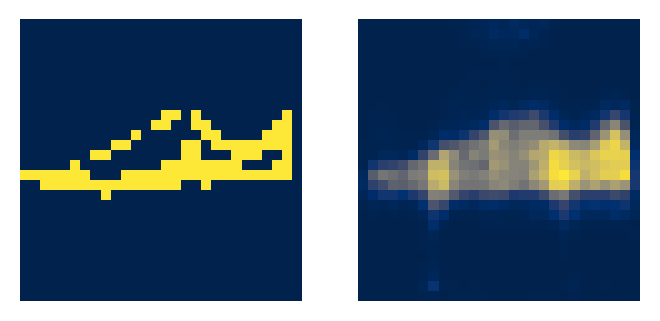

In [197]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2))

ix_target = 9
img_truth = X_test[ix_target].reshape(28, 28)
img_reconstruct = model_test.apply(state_vae.params, X_test, key)[2][1]
img_reconstruct = nn.sigmoid(img_reconstruct[ix_target]).reshape(28, 28)

ax[0].imshow(img_truth, cmap="cividis")
ax[1].imshow(img_reconstruct, cmap="cividis")

ax[0].axis("off")
ax[1].axis("off");

## Hard EM

In [285]:
model = UnamortisedVAEBernDelta(dim_latent, dim_obs[0], DeltaEncoder, Decoder)
model_test = hlax.models.VAEBern(dim_latent, dim_obs[0], Encoder, Decoder)

### Train phase

In [286]:
config_train = hlax.unamortised.load_config(config, model)
output_train = hlax.unamortised.train_checkpoints(key_train, config_train, X_warmup, iwae_bern_delta)
checkpoint_params = output_train["checkpoint_params"]
state_train = output_train["state_final"]

  0%|          | 0/100 [00:00<?, ?it/s]

### Test phase

In [287]:
params_decoder = state_train.params["params"]["decoder"]
params_test = model_test.init(key_init_test, X_test[:2], key_init_test)
params_test = unfreeze(params_test)
params_test["params"]["decoder"] = params_decoder
params_test = freeze(params_test)

tx = optax.adam(1e-4)
state = TrainState.create(
    apply_fn=model_test.apply,
    params=params_test,
    tx=tx
)

config_test = hlax.amortised.TrainConfig(
    num_epochs=200,
    batch_size=200
)

state_hem, hist_loss_hem = hlax.amortised.train_encoder(key_it_test, config_test, X_test, state, elbo_bern)

  0%|          | 0/200 [00:00<?, ?it/s]

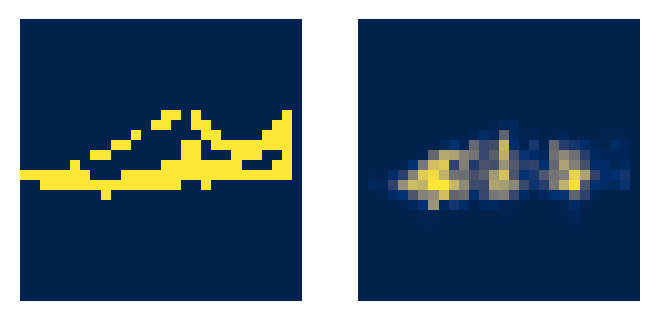

In [288]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2))

ix_target = 9
img_truth = X_test[ix_target].reshape(28, 28)
img_reconstruct = model_test.apply(state_hem.params, X_test, key)[2][1]
img_reconstruct = nn.sigmoid(img_reconstruct[ix_target]).reshape(28, 28)

ax[0].imshow(img_truth, cmap="cividis")
ax[1].imshow(img_reconstruct, cmap="cividis")

ax[0].axis("off")
ax[1].axis("off");

In [289]:
import seaborn as sns
from jax.flatten_util import ravel_pytree

In [290]:
pdecoder_hem, _ = ravel_pytree(state_hem.params["params"]["decoder"])
pdecoder_vae, _ = ravel_pytree(state_vae.params["params"]["decoder"])

df_decoder = pd.DataFrame({
    "hem": pdecoder_hem.to_py(),
    "vae": pdecoder_vae.to_py()
})

In [291]:
pencoder_hem, _ = ravel_pytree(state_hem.params["params"]["encoder"])
pencoder_vae, _ = ravel_pytree(state_vae.params["params"]["encoder"])

df_encoder = pd.DataFrame({
    "hem": pencoder_hem.to_py(),
    "vae": pencoder_vae.to_py()
})

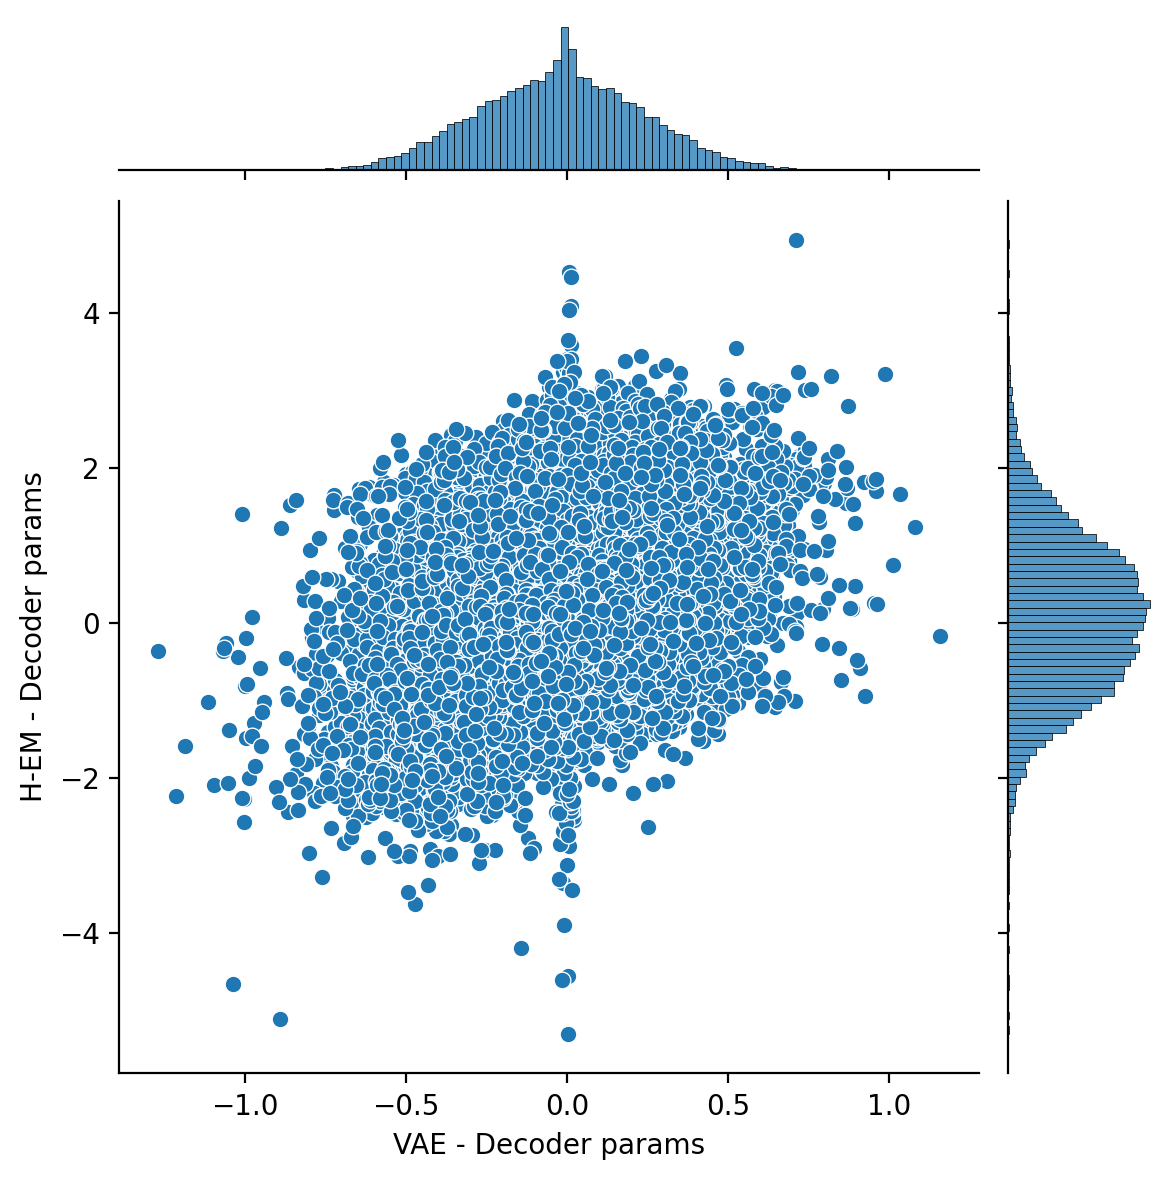

In [292]:
sns.jointplot(data=df_decoder, x="vae", y="hem")
plt.xlabel("VAE - Decoder params")
plt.ylabel("H-EM - Decoder params");

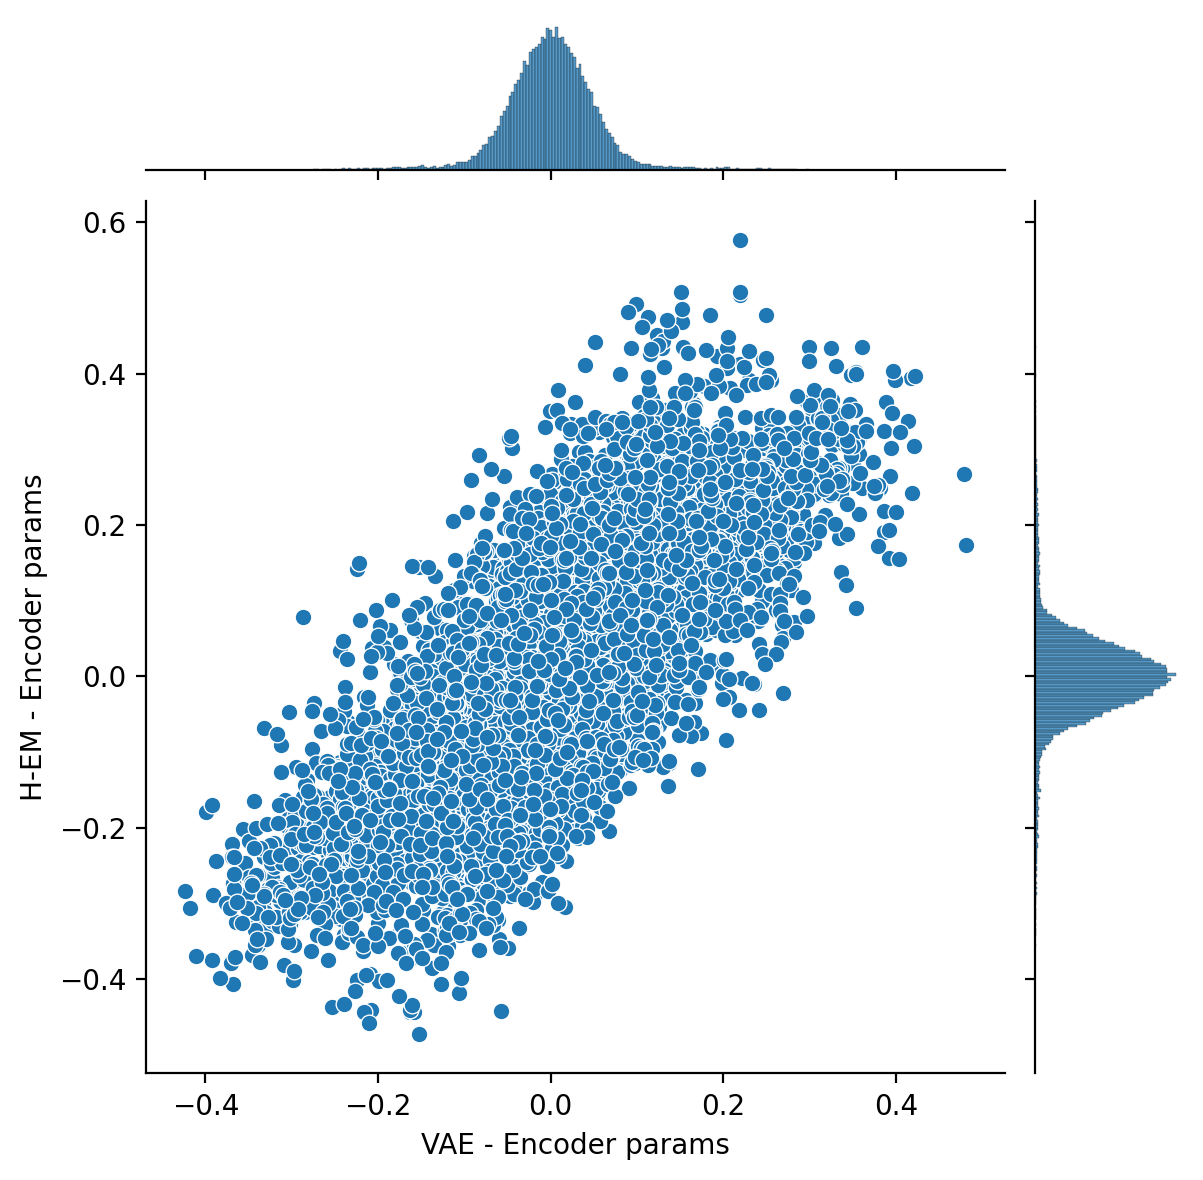

In [293]:
sns.jointplot(data=df_encoder, x="vae", y="hem")
plt.xlabel("VAE - Encoder params")
plt.ylabel("H-EM - Encoder params");

-----

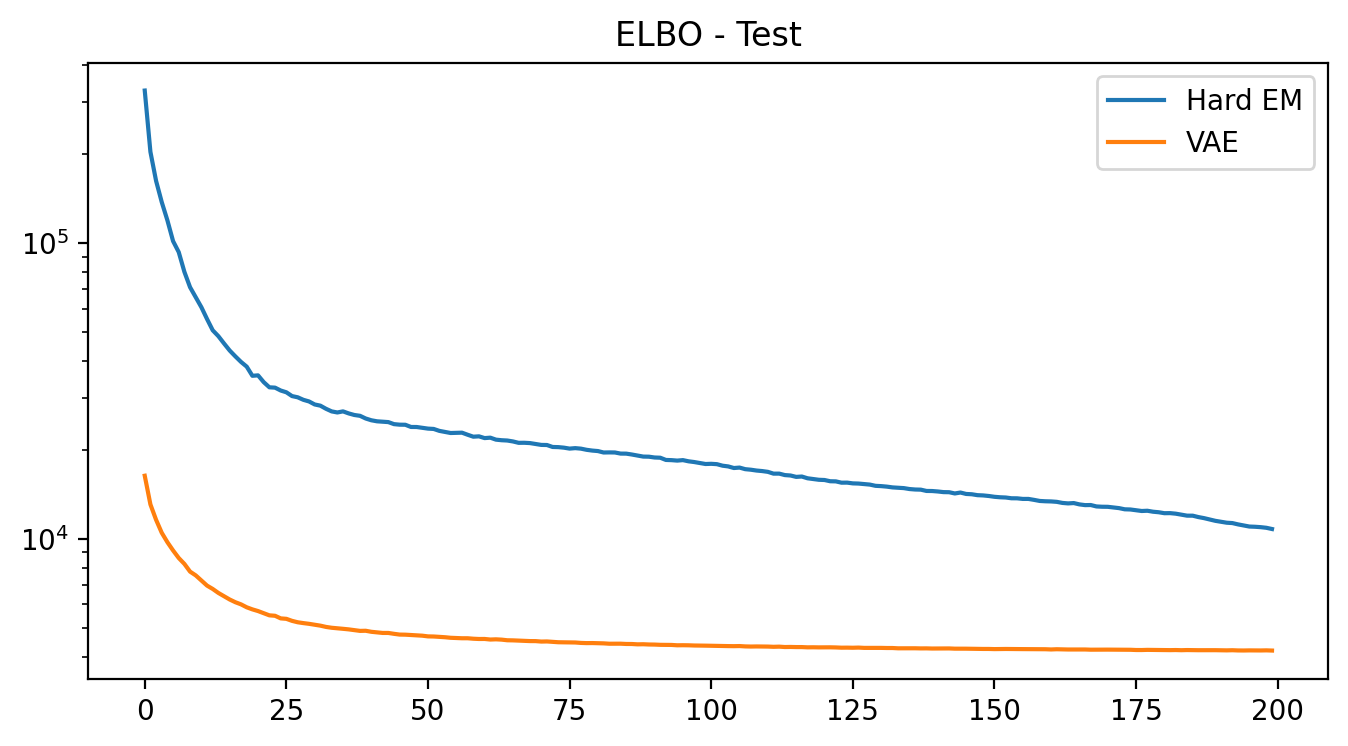

In [294]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.title("ELBO - Test")
plt.plot(hist_loss_hem, label="Hard EM")
plt.plot(hist_loss_vae, label="VAE")
plt.yscale("log")
plt.legend()

## Observe training results

In [185]:
ix_target = 1
model = model

state_final = state_hem
params= state_final.params
vals = model.apply(params, X_warmup, key)[1] #[-1][0]
# vals = model.apply(params, X_warmup, key)[-1][0]

img_reconstruct = vals[ix_target].reshape(28, 28)
img_reconstruct = nn.sigmoid(img_reconstruct)

img_target = X_warmup[ix_target].reshape(28, 28)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img_target, cmap="cividis")
ax[1].imshow(img_reconstruct, cmap="cividis")

ax[0].axis("off")
ax[1].axis("off");

ValueError: Inconsistent batch axis sizes: {30000, 50}

In [152]:
apply_fn = partial(config_test.model.apply, num_samples=10)


device_cpu = jax.devices("cpu")[0]

In [153]:
num_samples = 10
keys_eval = jax.random.split(key, num_samples)
# vmap_iwae = jax.vmap(iwae_bern, (0, None, None, None))
vmap_iwae = jax.vmap(iwae_bern_delta, (0, None, None, None))

res_list = [res_hem, res_vae, res_uvae]
labels = ["HEM", "VAE", "u-lvm"]

df_mll = []
elements = list(zip(res_list, labels))
for res, label in tqdm(elements):
    for ix_epoch in res["test"]["state"]:
        
        state_test = res["test"]["state"][ix_epoch]
        params_test = jax.device_put(state_test.params, device_cpu)
        is_mll = vmap_iwae(keys_eval, params_test, apply_fn, X_test)

        entry = {
            "label": label,
            "mll": is_mll.to_py(),
            "epoch": int(ix_epoch.lstrip("e")),
            "time": res["train"]["times"][ix_epoch],
        }

        df_mll.append(entry)
df_mll = pd.DataFrame(df_mll).explode("mll")

  0%|          | 0/3 [00:00<?, ?it/s]

In [154]:
mll_std = df_mll.pivot_table(index="epoch", columns="label", values="mll", aggfunc="std")
mll_mean = -df_mll.pivot_table(index="epoch", columns="label", values="mll", aggfunc="mean")

In [155]:
mll_mean

label,HEM,VAE,u-lvm
epoch,,,
50,-240.427588,-261.205542,-326.046777


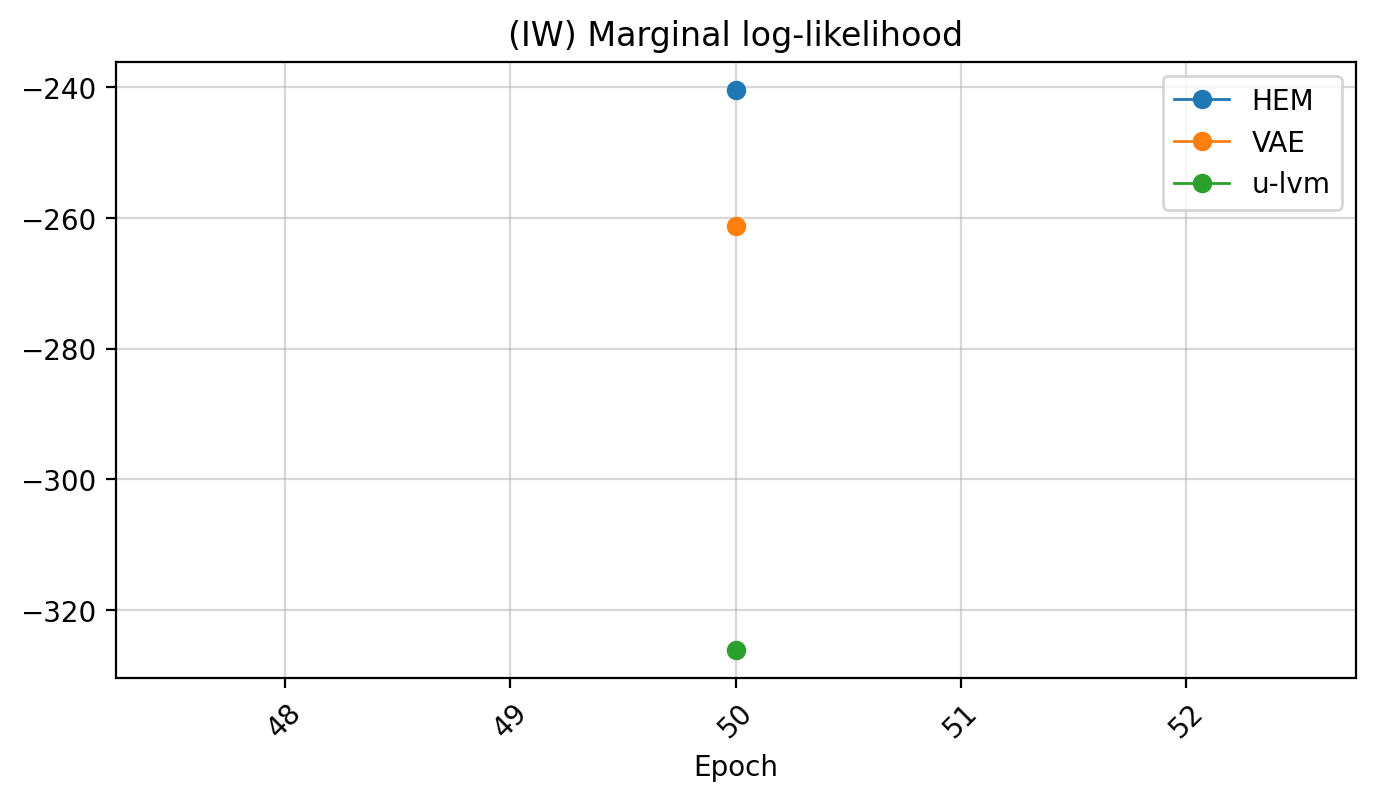

In [156]:
fig, ax = plt.subplots(figsize=(8, 4))
xvals = mll_mean.index
labels = ["HEM", "VAE", "u-lvm"]
for col in labels:
    mean = mll_mean[col]
    std = mll_std[col]
    
    plt.fill_between(xvals, mean - 2 * std, mean + 2 * std, alpha=0.5)
    plt.plot(xvals, mean, label=col, linewidth=1, marker="o")
    
plt.legend()
plt.title("(IW) Marginal log-likelihood")
plt.xlabel("Epoch")
plt.xticks(rotation=45)
plt.grid(alpha=0.5)